In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import sys

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


In [3]:
nsims= 5
trials =1000
skip_boot=False
skip_shi=False
refinement_test=True

c1 = .005
c2 = .0025

linspace=10
smoothing =5
adapt_c= False

# Size stuff

In [4]:
betas = np.linspace(0,3,linspace)
nobs = 100
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

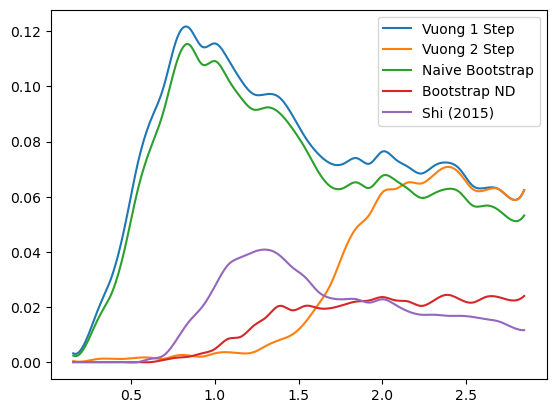

In [5]:
def create_fig(params,res,name='test.png'):
    results2 = np.array(res)
    
    col_labels = ['Param','Vuong 1 Step','Vuong 2 Step', 'Refinement Test','Shi (2015)', 'Naive Bootstrap','Bootstrap TIC','Bootstrap ND']



    np_results = np.concatenate((params.reshape(params.shape[0],1),results2[:,:,0]),axis=1)
    df_results = pd.DataFrame(data=np_results,columns=col_labels)
    df_results.to_csv("paper_figs/"+name[:-4]+".csv")
    
    ma2 = lambda x : np.convolve(x,np.ones(smoothing)/smoothing, mode='valid')
    params_new = np.linspace( ma2(params).min(),  ma2(params).max(), 300) 
    interp = lambda x: make_interp_spline(ma2(params), ma2(x), k=3)(params_new)


    plt.plot(params_new, interp(1-results2[:,0,0]) ,label='Vuong 1 Step')
    plt.plot(params_new, interp(1-results2[:,1,0]) ,label='Vuong 2 Step')
    
    if not skip_boot:
        plt.plot(params_new,interp(1-results2[:,4,0]),label='Naive Bootstrap')
        plt.plot(params_new,interp(1-results2[:,6,0]),label='Bootstrap ND')
        
    if not skip_shi:
        plt.plot(params_new,interp(1-results2[:,3,0]),label='Shi (2015)')

    plt.legend()
    plt.savefig('paper_figs/'+name,dpi=300)
    plt.show()

name = 'size_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

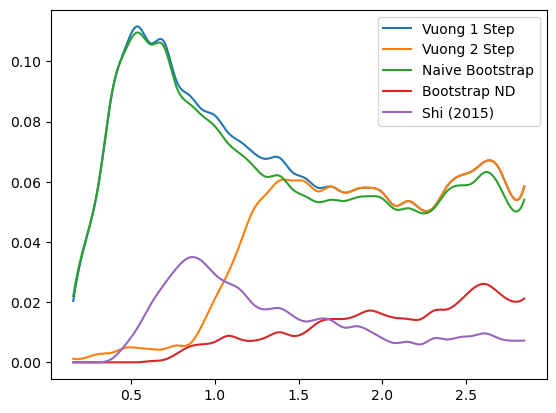

In [6]:
betas = np.linspace(0,3,linspace)
nobs =250
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'size_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

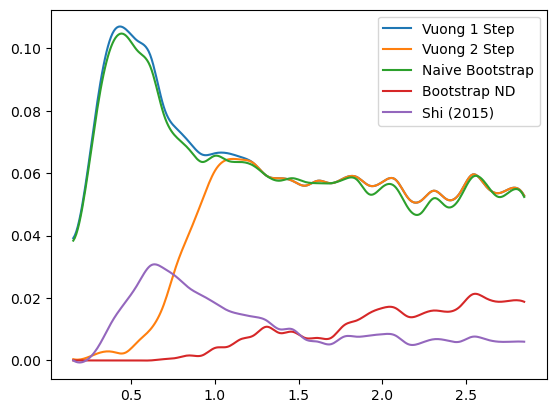

In [7]:
betas = np.linspace(0,3,linspace)
nobs = 500
results = []

for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn,num_params=num_params)
    gen_data_ex = lambda : gen_data(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])


name = 'size_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

# Power stuff

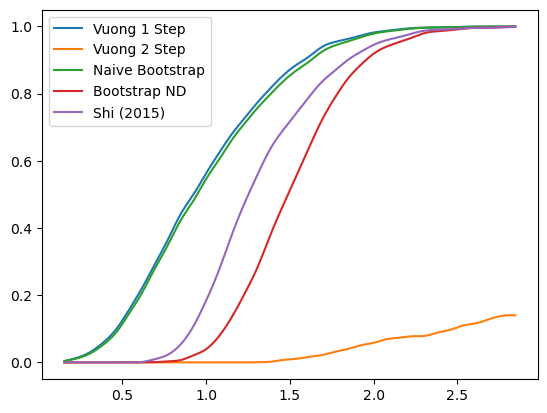

In [8]:
def gen_data3(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([0,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

betas = np.linspace(0,3,linspace)
nobs = 100
results = []


for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

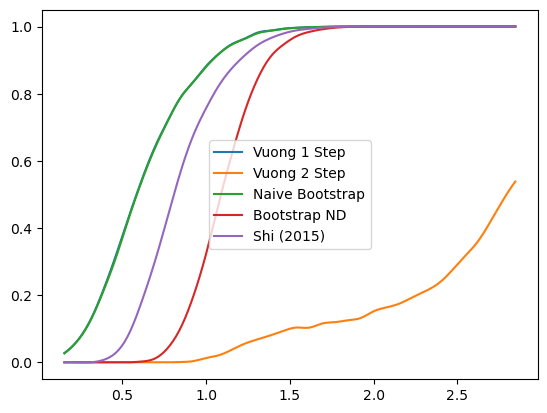

In [9]:
betas = np.linspace(0,3,linspace)
nobs = 250
results = []


for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)

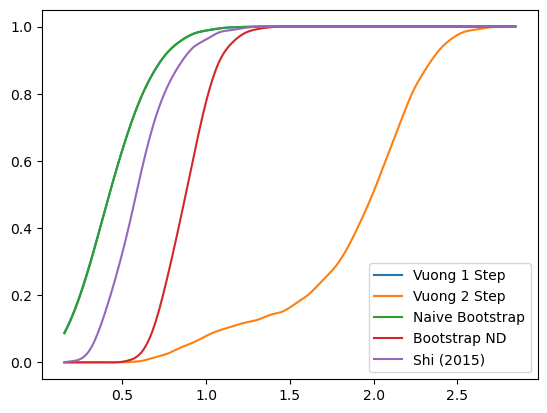

In [10]:

betas = np.linspace(0,3,linspace)
nobs = 500
results = []


for beta in betas:
    setup_shi_ex  = lambda yn,xn: setup_shi(yn,xn)
    gen_data_ex = lambda : gen_data3(nobs=nobs, beta =beta)
    mc_out = vuong_tests_fast.monte_carlo(nsims,gen_data_ex,setup_shi_ex,trials=trials,
                                          skip_boot=skip_boot,skip_shi=skip_shi,refinement_test=refinement_test,c1=c1,c2=c2)
    reg,twostep, refine_test, boot1,boot2,boot3,shi, llr,std, omega = mc_out
    results.append([reg,twostep,refine_test,shi,boot1,boot2,boot3])

name = 'power_nobs%s_c1%s_c2%s_trials%s.png'%(nobs,c1,c2,trials)
create_fig(betas,results,name=name)